In [1]:
import os
os.environ["SPARK_VERSION"] = "3.1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.sql import SparkSession

from pyspark.sql.functions import count, round, concat
from pyspark.sql.functions import mean, min, max, sum, datediff, to_date
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit, datediff, col
import pyspark.sql.functions as func
from pyspark.sql.functions import when


In [2]:
#!pip install pydeequ

import pydeequ
from pydeequ.checks import *
from pydeequ.verification import *
from pydeequ.analyzers import *
from pydeequ.anomaly_detection import *
from pydeequ.profiles import *

In [3]:
# spark = SparkSession \
#     .builder \
#     .appName("testData") \
#     .config("spark.some.config.option", "some-value") \
#     .getOrCreate()
spark = SparkSession.builder.appName("testData").getOrCreate()

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
data = spark.read.csv('testData.csv', header='true')

In [6]:
df = data.toPandas()

In [7]:
df.head()

,status,bed,bath,acre_lot3,city,state,zip_code,acre_lot7,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,None,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,None,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,None,67000.0
3,for_sale,4.0,2.0,0.1,Ponce,Puerto Rico,731.0,1800.0,None,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,None,None,65000.0


In [8]:
data.show(5)

+--------+---+----+---------+----------+-----------+--------+---------+--------------+--------+
|  status|bed|bath|acre_lot3|      city|      state|zip_code|acre_lot7|prev_sold_date|   price|
+--------+---+----+---------+----------+-----------+--------+---------+--------------+--------+
|for_sale|3.0| 2.0|     0.12|  Adjuntas|Puerto Rico|   601.0|    920.0|          null|105000.0|
|for_sale|4.0| 2.0|     0.08|  Adjuntas|Puerto Rico|   601.0|   1527.0|          null| 80000.0|
|for_sale|2.0| 1.0|     0.15|Juana Diaz|Puerto Rico|   795.0|    748.0|          null| 67000.0|
|for_sale|4.0| 2.0|      0.1|     Ponce|Puerto Rico|   731.0|   1800.0|          null|145000.0|
|for_sale|6.0| 2.0|     0.05|  Mayaguez|Puerto Rico|   680.0|     null|          null| 65000.0|
+--------+---+----+---------+----------+-----------+--------+---------+--------------+--------+
only showing top 5 rows



In [9]:
data.printSchema()

root
 |-- status: string (nullable = true)
 |-- bed: string (nullable = true)
 |-- bath: string (nullable = true)
 |-- acre_lot3: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- acre_lot7: string (nullable = true)
 |-- prev_sold_date: string (nullable = true)
 |-- price: string (nullable = true)



In [10]:
def my_count(df_in):
    df_in.agg( *[ count(c).alias(c) for c in df_in.columns ] ).show()
    
my_count(data)

+------+------+------+---------+------+------+--------+---------+--------------+------+
|status|   bed|  bath|acre_lot3|  city| state|zip_code|acre_lot7|prev_sold_date| price|
+------+------+------+---------+------+------+--------+---------+--------------+------+
|904966|775126|791082|   638324|904894|904966|  904762|   612080|        445865|904895|
+------+------+------+---------+------+------+--------+---------+--------------+------+



In [11]:
data = data.dropna()
my_count(data)

+------+------+------+---------+------+------+--------+---------+--------------+------+
|status|   bed|  bath|acre_lot3|  city| state|zip_code|acre_lot7|prev_sold_date| price|
+------+------+------+---------+------+------+--------+---------+--------------+------+
|226626|226626|226626|   226626|226626|226626|  226626|   226626|        226626|226626|
+------+------+------+---------+------+------+--------+---------+--------------+------+



In [12]:
for c in data.columns:
    if data.schema[c].dataType in [int, float]:
        data = data.withColumn(c, func.round(data[c], 3).cast('integer'))


In [13]:
data.printSchema()

root
 |-- status: string (nullable = true)
 |-- bed: string (nullable = true)
 |-- bath: string (nullable = true)
 |-- acre_lot3: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- acre_lot7: string (nullable = true)
 |-- prev_sold_date: string (nullable = true)
 |-- price: string (nullable = true)



In [14]:
data.show(2)

+--------+---+----+---------+------+-----------+--------+---------+--------------+--------+
|  status|bed|bath|acre_lot3|  city|      state|zip_code|acre_lot7|prev_sold_date|   price|
+--------+---+----+---------+------+-----------+--------+---------+--------------+--------+
|for_sale|7.0| 3.0|     0.09|Dorado|Puerto Rico|   949.0|   1192.0|    2019-06-28|110000.0|
|for_sale|7.0| 3.0|     0.09|Dorado|Puerto Rico|   949.0|   1192.0|    2019-06-28|110000.0|
+--------+---+----+---------+------+-----------+--------+---------+--------------+--------+
only showing top 2 rows



In [15]:
cols = data.columns[0:9]
data.select(cols).describe().show()

+-------+--------+------------------+------------------+-----------------+--------+--------------+-----------------+------------------+--------------+
|summary|  status|               bed|              bath|        acre_lot3|    city|         state|         zip_code|         acre_lot7|prev_sold_date|
+-------+--------+------------------+------------------+-----------------+--------+--------------+-----------------+------------------+--------------+
|  count|  226626|            226626|            226626|           226626|  226626|        226626|           226626|            226626|        226626|
|   mean|    null|3.6635072763054546|2.6175858021586227| 4.88209596427591|    null|          null|6571.348058033941| 2295.169067097332|          null|
| stddev|    null|1.5220413874511376| 1.416195151952199|206.5699091524893|    null|          null|4177.120875958267|2024.1620972080298|          null|
|    min|for_sale|               1.0|               1.0|              0.0|Aberdeen|   Connecti

In [16]:
data.groupBy("price").count().sort(col('price')).show()

+----------+-----+
|     price|count|
+----------+-----+
|   10000.0|   17|
|  100000.0|  305|
| 1000000.0|  154|
|10000000.0|    4|
|  100700.0|    4|
| 1010000.0|   11|
|  101500.0|    7|
| 1018000.0|    3|
|  102000.0|    5|
| 1025000.0|  115|
|10250000.0|   30|
| 1028888.0|    2|
|  103000.0|    2|
| 1030000.0|   25|
| 1035000.0|   31|
| 1037000.0|    2|
| 1038800.0|   12|
| 1039000.0|   23|
|  104500.0|    6|
| 1048000.0|    1|
+----------+-----+
only showing top 20 rows



In [17]:
def histogram(df, col, bins=10, xname=None, yname=None):

    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)

    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    plt.bar(loc, vals[1], width=width)
    plt.xlabel(col)
    plt.ylabel(yname)
    plt.show()

In [18]:

# histogram(data, 'price', bins=500,xname='price', yname='state')

In [19]:
# from pyspark.sql import functions as F

# # Perform aggregation
# aggregated_data = data.agg(F.avg('acre_lot').alias('avg_acre_lot'), F.avg('house_size').alias('avg_house_size')) \
#     .sort('avg_acre_lot')

# # Show the aggregated data
# aggregated_data.show()


In [20]:
def lineplot(df, x, y, measure='mean'):    
    if measure == 'mean':
        pd_df = df.groupBy(x).mean(y).toPandas().sort_values(by=x)
        pd_df.plot(x, 'avg({})'.format(y), legend=False)
    elif measure == 'total':
        pd_df = df.groupBy(x).sum(y).toPandas().sort_values(by=x)
        pd_df.plot(x, 'sum({})'.format(y), legend=False)
    elif measure == 'count':
        pd_df = df.groupBy(x).count().toPandas().sort_values(by=x)
        pd_df.plot(x, 'count', legend=False)
    plt.ylabel(y)
    plt.show()

In [21]:
# lineplot(data, 'price', 'bed', measure='mean')

In [22]:
# lineplot(data, 'acre_lot', 'price', measure='mean')

In [23]:
area_lot_count =(data.groupBy('status').count().sort('status').cache())
                                         
area_lot_count = area_lot_count.count()
print('Found %d response codes' % area_lot_count)


Found 1 response codes


In [24]:
# histogram(data, 'status', bins=300)

In [25]:
#remove all whitespaces from every single column in the Dataframe
tempList = [] 
for col in df.columns:
  new_name = col.strip()
  new_name = "".join(new_name.split())
  new_name = new_name.replace('.','')  
  tempList.append(new_name) 
print(tempList)

data = data.toDF(*tempList)

['status', 'bed', 'bath', 'acre_lot3', 'city', 'state', 'zip_code', 'acre_lot7', 'prev_sold_date', 'price']


In [26]:
data = data.withColumn('status', round(data['acre_lot3'] / data['bed'], 2))
data.show(10)

+------+---+----+---------+------------+--------------+--------+---------+--------------+---------+
|status|bed|bath|acre_lot3|        city|         state|zip_code|acre_lot7|prev_sold_date|    price|
+------+---+----+---------+------------+--------------+--------+---------+--------------+---------+
|  0.01|7.0| 3.0|     0.09|      Dorado|   Puerto Rico|   949.0|   1192.0|    2019-06-28| 110000.0|
|  0.01|7.0| 3.0|     0.09|      Dorado|   Puerto Rico|   949.0|   1192.0|    2019-06-28| 110000.0|
|  0.01|7.0| 3.0|     0.09|      Dorado|   Puerto Rico|   949.0|   1192.0|    2019-06-28| 110000.0|
|  0.01|7.0| 3.0|     0.09|      Dorado|   Puerto Rico|   949.0|   1192.0|    2019-06-28| 110000.0|
|  0.01|7.0| 3.0|     0.09|      Dorado|   Puerto Rico|   949.0|   1192.0|    2019-06-28| 110000.0|
|   0.2|5.0| 4.0|     0.99|Saint Thomas|Virgin Islands|   802.0|   5000.0|    2013-10-11| 950000.0|
|  0.21|4.0| 6.0|     0.83|Saint Thomas|Virgin Islands|   802.0|   4600.0|    2018-04-05|6899000.0|


In [27]:
data.filter((data['status']==0.01) & (data['price']>1100) & (data['acre_lot7']>1190)).show()
data.show(2)

+------+---+----+---------+------+-----------+--------+---------+--------------+--------+
|status|bed|bath|acre_lot3|  city|      state|zip_code|acre_lot7|prev_sold_date|   price|
+------+---+----+---------+------+-----------+--------+---------+--------------+--------+
|  0.01|7.0| 3.0|     0.09|Dorado|Puerto Rico|   949.0|   1192.0|    2019-06-28|110000.0|
|  0.01|7.0| 3.0|     0.09|Dorado|Puerto Rico|   949.0|   1192.0|    2019-06-28|110000.0|
|  0.01|7.0| 3.0|     0.09|Dorado|Puerto Rico|   949.0|   1192.0|    2019-06-28|110000.0|
|  0.01|7.0| 3.0|     0.09|Dorado|Puerto Rico|   949.0|   1192.0|    2019-06-28|110000.0|
|  0.01|7.0| 3.0|     0.09|Dorado|Puerto Rico|   949.0|   1192.0|    2019-06-28|110000.0|
|  0.01|7.0| 3.0|     0.09|Dorado|Puerto Rico|   949.0|   1192.0|    2019-06-28|110000.0|
|  0.01|7.0| 3.0|     0.09|Dorado|Puerto Rico|   949.0|   1192.0|    2019-06-28|110000.0|
|  0.01|7.0| 3.0|     0.09|Dorado|Puerto Rico|   949.0|   1192.0|    2019-06-28|110000.0|
|  0.01|7.

In [28]:
data = data.withColumn('status', 
                       when((data['price'] > 10000) & (data['acre_lot7'] ==4000), 1) \
                       .when((data['acre_lot7'] > 0.1), 1) \
                       .otherwise(0))

data.head(2)

[Row(status=1, bed='7.0', bath='3.0', acre_lot3='0.09', city='Dorado', state='Puerto Rico', zip_code='949.0', acre_lot7='1192.0', prev_sold_date='2019-06-28', price='110000.0'),
 Row(status=1, bed='7.0', bath='3.0', acre_lot3='0.09', city='Dorado', state='Puerto Rico', zip_code='949.0', acre_lot7='1192.0', prev_sold_date='2019-06-28', price='110000.0')]

In [29]:
def pieplot(df, col, lim=10, yname=None):

    classes = df.groupBy(col).count().orderBy('count', ascending=False)
    
    pd_df = classes.limit(lim).toPandas()
    
    pd_df.plot(kind='pie', x=col, y='count', \
           labels=pd_df[col], legend=False)
    plt.ylabel(None)
    plt.show()

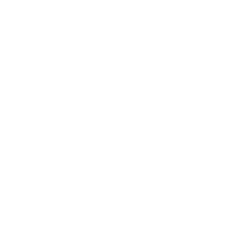

In [30]:
data_graph = data.filter((data['acre_lot7']==0.1) & (data['price'] > 1400))
pieplot(data_graph, 'acre_lot7')

In [31]:
def boxplot(df, col, group_by): 
    pd_df = df.toPandas()
    pd_df.boxplot(col, by=group_by, figsize=(8, 5))
    plt.ylabel(col)
    plt.title(None)
    plt.show()

In [32]:
# boxplot(data, 'price','city')

In [33]:
# # Initialization of a test
# check = Check(spark, CheckLevel.Error, "Integrity checks")

# # testData overview / data testing
# checkResult = VerificationSuite(spark) \
#     .onData(data) \
#     .addCheck(
#         check.hasSize(lambda x: x >= 50) \
#         .hasMin("price", lambda x: x > 0) \
#         .isComplete("status")  \
#         .isUnique("prev_sold_date")  \
#         .isNonNegative("price")) \
#     .run()

# # Running verification
# checkResult_df = VerificationResult.checkResultsAsDataFrame(spark, checkResult)
# checkResult_df.show()

# # Describing the result
# if checkResult.status == "Success":
#     print('Tests passed')
# else:
#     print('Errors found:')

#     for check_json in checkResult.checkResults:
#         if check_json['constraint_status'] != "Success":
#             print(f"\t{check_json['constraint']} reason: {check_json['constraint_message']}")


In [34]:
# analysisResult = AnalysisRunner(spark) \
#                     .onData(data) \
#                     .addAnalyzer(Size()) \
#                     .addAnalyzer(Completeness("price")) \
#                     .addAnalyzer(ApproxCountDistinct("city")) \
#                     .addAnalyzer(Mean("acre_lot")) \
#                     .addAnalyzer(Compliance("acre_lot", "acre_lot >= 140.0")) \
#                     .addAnalyzer(Correlation("bed", "bath")) \
#                     .run()
                    
# analysisResult_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult)
# analysisResult_df.show()

In [35]:
# result = ColumnProfilerRunner(spark) \
#     .onData(data) \
#     .run()

# for col, profile in result.profiles.items():
#     print(profile)

In [36]:
# anomalyResult = VerificationSuite(spark) \
#     .onData(data) \
#     .addAnomalyCheck(BatchNormalStrategy(lowerDeviationFactor=3.0, upperDeviationFactor=3.0, includeInterval=False)) \
#     .run()

# anomalyResult = VerificationResult.checkResultsAsDataFrame(spark, anomalyResult)
# anomalyResult.show()

In [2]:
# spark.stop()